In [1]:
import numpy as np
import torch
import pandas as pd
import seaborn as sb

from utils.tools import load_yaml
from dataset import create_dataset
from model.UNet import UNet
from model.UNetPredictor import UNetPredictor
import torch

from pathlib import Path
import joblib

from tqdm import tqdm

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms import functional as TF
from PIL import Image  # For compatibility with torchvision.transforms
from skimage.filters import threshold_multiotsu
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
import cv2

In [2]:
config = load_yaml("config.yml", encoding="utf-8")
_, param_scaler, prop_scaler = create_dataset(**config["Dataset"])

# either predictor or diffusion
model_type = 'predictor'

if model_type == 'diffusion':
    cp = torch.load("checkpoint/unet.pth",  map_location=torch.device('cpu'))
    model = UNet(**config["Model"])

else:
    cp = torch.load("predictor/unet.pth",  map_location=torch.device('cpu'))
    model = UNetPredictor(**config["ModelPredictor"])

model.load_state_dict(cp["model"])
model = model.eval()

In [25]:
df.columns

Index(['diameter', 'pitch', 'nQWs', 'growth_Temp_QW', 'AsP_QW', 'InP_barrier',
       'growth_time_cap', 'lasing_threshold', 'lasing_wavelength',
       'lasing_threshold_corr_from_2', 'lasing_wl_corr_from_2',
       'scale_factor_um_px', 'inner_radius_um', 'outer_radius_um',
       'ring_width_um', 'processed_image'],
      dtype='object')

In [3]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, param_scaler, prop_scaler):
        
        self.images = [np.array(img, dtype=np.uint8) for img in dataframe['processed_image']]
        self.images = np.array(self.images)
    
        self.batches = [idx[0] for idx in dataframe['processed_image'].index]
    
        self.transform = v2.Compose([
            #v2.RandomHorizontalFlip(p=0.5),
            #v2.RandomVerticalFlip(p=0.5),
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),  # Converts [0, 255] to [0, 1]
            v2.Normalize(mean=[0.5], std=[0.5]),    # Maps [0, 1] → [-1, 1]
        ])
    
        self.params = dataframe[['diameter', 'pitch', 'nQWs', 'growth_Temp_QW', 'AsP_QW', 'InP_barrier','growth_time_cap']].values
        self.prop = dataframe[['lasing_threshold_corr_from_2', 'lasing_wl_corr_from_2']].values
    
        self.param_scaler = param_scaler
        self.prop_scaler = prop_scaler
        
    
    def __len__(self):
        return len(self.images)
    
    def preprocessing(self):
    
        self.params_norm = self.param_scaler.fit_transform(self.params)
        self.params_norm = torch.tensor(self.params_norm, dtype=torch.float32)
        self.prop_norm = self.prop_scaler.fit_transform(self.prop)
        self.prop_norm = torch.tensor(self.prop_norm, dtype=torch.float32)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        image = v2.Resize((128, 128))(image) 
    
        param = self.params_norm[idx]
        prop = self.prop_norm[idx]
    
        batch = self.batches[idx]
        
        return image, param, prop, batch



In [4]:
df = pd.read_pickle(f"dataset/merged_all_batches_diffusion.pkl")
dataset = ImageDataset(df, param_scaler, prop_scaler)
dataset.preprocessing()

loader_params = dict(
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=4,
)

dataloader = DataLoader(dataset, batch_size=64, **loader_params)

In [13]:
group_mapping = {
    'A': 'Batch1',
    'B': 'Batch1', 
    'C': 'Batch1',
    'D': 'Batch1',
    'E': 'Batch1',
    'F': 'Batch1',
    'G': 'Batch2',
    'H': 'Batch2',
    'I': 'Batch2',
    'J': 'Batch2',
    'DoE': 'Batch2.1',
    'L1': 'Batch3A',
    'L2': 'Batch3B',
    'M1': 'Batch3A',
    'M2': 'Batch3B',
    'N1': 'Batch3A',
    'N2': 'Batch3B',
    'O1': 'Batch3A',
    'O2': 'Batch3B',
}

In [5]:
# Collect embeddings for each layer
embeddings, all_embeddings = {}, {}
all_images, all_params, all_props, all_id = [], [], [], []

for i, layer in enumerate(model.middle_block):
    all_embeddings[i] = []

def get_hook(idx):
    def hook(module, input, output):
        # Save output embedding for this layer index
        embeddings[idx] = output.detach().cpu()
    return hook

# Attach hook to every layer in middle_block
for i, layer in enumerate(model.middle_block):
    layer.register_forward_hook(get_hook(i))

with tqdm(dataloader, dynamic_ncols=True, colour="#ff924a") as data:
    for batch in data:    
        images, params, props, batch_id = batch
        with torch.no_grad():
            if model_type == 'diffusion':
                t = torch.zeros(images.shape[0],)
                _ = model(images, params, t, objectives=None, cfg_mask=None)
            else:
                _ = model(images, params)

        # Save embeddings + labels
        for i, layer in enumerate(model.middle_block):
            emb = embeddings[i]
            length = emb.shape[0]
            emb = emb.reshape(length, -1).cpu().numpy() # reshape into number of samples only
            all_embeddings[i].append(emb)

        all_images.append(images.cpu().numpy())
        all_params.append(params.cpu().numpy())
        all_props.append(props.cpu().numpy())
        all_id.append(list(batch_id))

for i, layer in enumerate(model.middle_block):
    all_embeddings[i] = np.array(all_embeddings[i]).reshape(-1, emb.shape[-1]) # restacks the batches, using emb's latent dimensionality

all_images = np.concatenate(all_images, axis=0)
all_params = np.concatenate(all_params, axis=0)   # [N, param_dim]
all_props = np.concatenate(all_props, axis=0)  # [N, prop_dim]
all_id = np.concatenate(all_id, axis=0)

all_images = np.squeeze(all_images, axis=1) # [N, height, width]
all_params = param_scaler.inverse_transform(all_params)
all_props = prop_scaler.inverse_transform(all_props)

print(f"Embeddings have {len(model.middle_block)} layers of shape {all_embeddings[0].shape}")
print(f"Images have shape {all_images.shape}")
print(f"Params have shape {all_params.shape}")
print(f"Props have shape {all_props.shape}")
print(f"Batches have shape {all_id.shape}")

  0%|          | 0/140 [00:00<?, ?it/s]/home/users/kaiyuana001/.conda/envs/microring/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 140/140 [03:23<00:00,  1.45s/it]


Embeddings have 4 layers of shape (8960, 32768)
Images have shape (8960, 128, 128)
Params have shape (8960, 7)
Props have shape (8960, 2)
Batches have shape (8960,)


In [11]:
layer_embeddings = all_embeddings[3]
emb_pca = PCA(n_components=2).fit_transform(layer_embeddings)

In [30]:
(all_id==key).reshape(-1)

array([False, False, False, ..., False, False, False])

/tmp/ipykernel_2794766/2233462508.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(emb_pca[mask][:,0], emb_pca[mask][:,1],


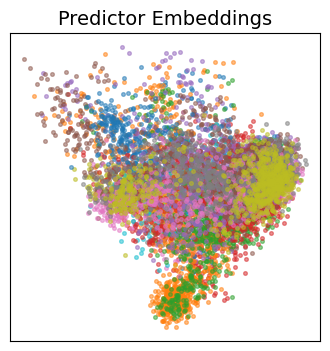

In [31]:

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))

for key in group_mapping.keys():
    mask = (all_id==key).reshape(-1)
    ax.scatter(emb_pca[mask][:,0], emb_pca[mask][:,1],
            #c = all_props[:,0],
            #c = all_params[:,1],
            alpha=0.5, cmap="rainbow", s=7,
            label=key,
            )

ax.set_title(f"Predictor Embeddings", fontsize=14)
'''
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Threshold')
'''

ax.set_yticks([])
ax.set_xticks([])
#plt.tight_layout()
plt.show()

/home/users/kaiyuana001/.conda/envs/microring/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/users/kaiyuana001/.conda/envs/microring/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)


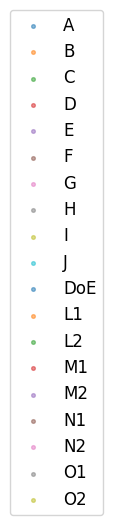

In [34]:
figsize = (0, 0)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', fontsize=12)
ax_leg.set_xticks([])
ax_leg.set_yticks([])
fig_leg.set_frameon(False)

In [69]:
group_mapping = {
    'A': 'Batch1',
    'B': 'Batch1', 
    'C': 'Batch1',
    'D': 'Batch1',
    'E': 'Batch1',
    'F': 'Batch1',
    'G': 'Batch2',
    'H': 'Batch2',
    'I': 'Batch2',
    'J': 'Batch2',
    'DoE': 'Batch2.1',
    'L1': 'Batch3A',
    'L2': 'Batch3B',
    'M1': 'Batch3A',
    'M2': 'Batch3B',
    'N1': 'Batch3A',
    'N2': 'Batch3B',
    'O1': 'Batch3A',
    'O2': 'Batch3B',
    
}

# Assign groups
batch_num = []
for string in all_id:
    if string in group_mapping:
        batch_num.append(group_mapping[string])

In [94]:
all_id[np.argsort(all_id)]

array(['A', 'A', 'A', ..., 'O2', 'O2', 'O2'], dtype='<U3')

In [39]:
sorted(set(batch_num))

['Batch1', 'Batch2', 'Batch2.1', 'Batch3']

In [78]:
unique_cat = sorted(set(batch_num))
color_values = np.linspace(0, 1, len(unique_cat))
color_map = {cat: val for cat, val in zip(unique_cat, color_values)}
colors = [color_map[cat] for cat in batch_num]

In [75]:
colors = []
for i in batch_num:
    if i == 'Batch3A':
        colors.append('r')
    elif i == 'Batch3B':
        colors.append('b')
    else:
        colors.append('k')

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded = le.fit_transform(all_id[np.argsort(all_id)])

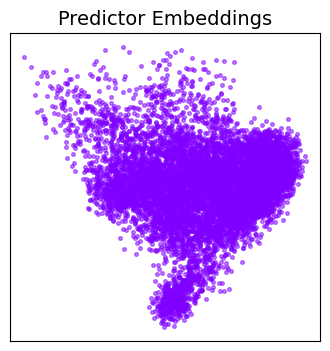

In [9]:




'''
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=plt.cm.rainbow(val), 
                            markersize=10, label=cat) 
                 for cat, val in zip(unique_cat, color_values)]
ax.legend(handles=legend_elements, title='Categories')
'''

'''
interesting_rings = emb_pca[(emb_pca[:,0]<0) & (emb_pca[:,0]>-200) & (emb_pca[:,1]<-300)]
for i in range(len(interesting_rings)):
    circle = plt.Circle((interesting_rings[i,0], interesting_rings[i,1]), 35, color='r', fc='None')
    ax.add_patch(circle)
'''

if model_type == 'diffusion':
    plot_title = 'Diffusion'
else:
    plot_title = 'Predictor'
 
ax.set_title(f"{plot_title} Embeddings", fontsize=14)
'''
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Threshold')
'''

ax.set_yticks([])
ax.set_xticks([])
#plt.tight_layout()
plt.show()

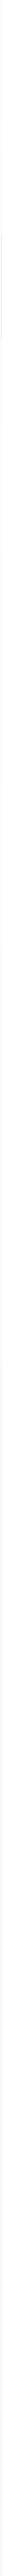

In [10]:
figsize = (2, 2)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', fontsize=12)
ax_leg.set_xticks([])
ax_leg.set_yticks([])
fig_leg.set_frameon(False)

In [90]:
fig_legend = plt.figure(figsize=(3, 2)) # Adjust figsize as needed
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=plt.cm.rainbow(val), 
                            markersize=10, label=cat) 
                 for cat, val in zip(unique_cat, color_values)]
fig_legend.legend(legend_elements, loc='center')
fig_legend.gca().axis('off')


TypeError: A single argument passed to legend() must be a list of labels, but found an Artist in there.

<Figure size 300x200 with 0 Axes>

In [57]:
interesting_rings = all_images[(emb_pca[:,0]<0) & (emb_pca[:,0]>-200) & (emb_pca[:,1]<-300)]
interesting_rings.shape

(451, 128, 128)

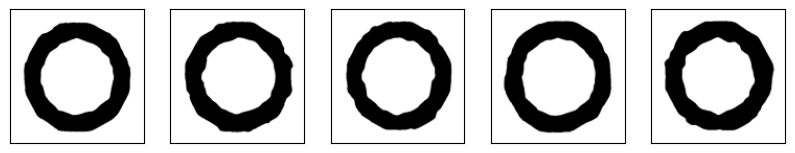

In [68]:
interesting_rings = all_images[(emb_pca[:,0]<0) & (emb_pca[:,0]>-200) & (emb_pca[:,1]<-300)]

fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))

for i in range(5):
    ax[i].imshow(interesting_rings[i,:], cmap='Greys',)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

[]

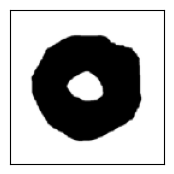

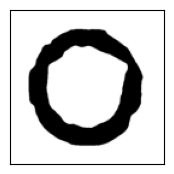

In [56]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax.imshow(all_images[all_props[:,0].argmax()], cmap='Greys',)
ax.set_yticks([])
ax.set_xticks([])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
ax.imshow(all_images[all_props[:,0].argmin()], cmap='Greys',)
ax.set_yticks([])
ax.set_xticks([])

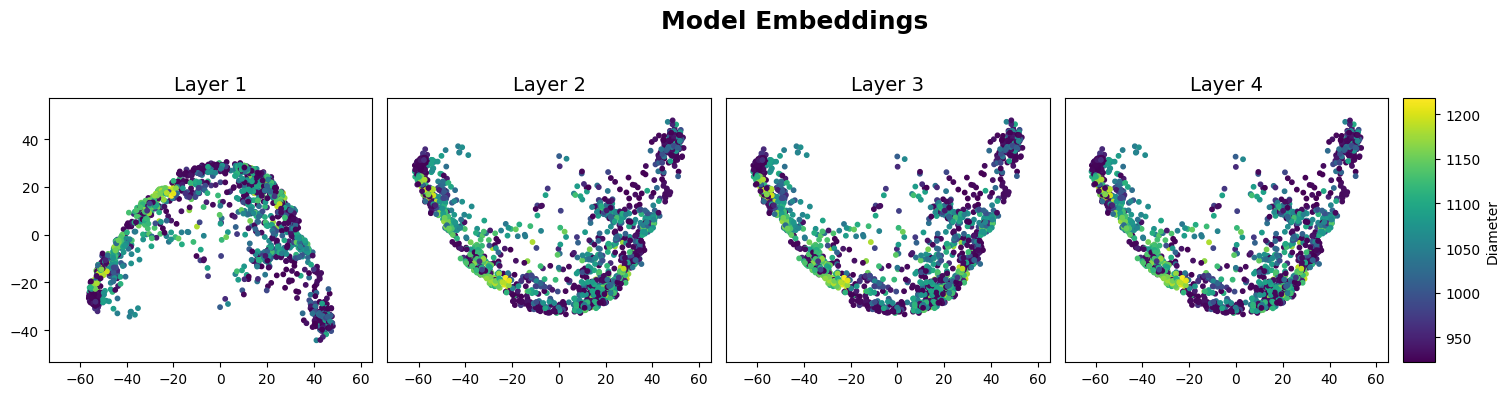

In [11]:

# Use GridSpec for better control over subplot sizes
fig = plt.figure(figsize=(4*len(model.middle_block),4))
gs = GridSpec(1, len(model.middle_block) + 1, width_ratios=[1]*len(model.middle_block) + [0.1])

axes = []
for i in range(len(model.middle_block)):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

# Find global min/max for consistent scaling across all plots
all_pca_points = []
for i in range(len(model.middle_block)):
    layer_embeddings = all_embeddings[i]
    emb_pca = PCA(n_components=2).fit_transform(layer_embeddings)
    all_pca_points.append(emb_pca)

all_pca_points = np.vstack(all_pca_points)
x_min, x_max = all_pca_points[:, 0].min(), all_pca_points[:, 0].max()
y_min, y_max = all_pca_points[:, 1].min(), all_pca_points[:, 1].max()

# Add some padding to the limits
x_padding = (x_max - x_min) * 0.1
y_padding = (y_max - y_min) * 0.1
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

for i, ax iprop_scaler.inverse_transform(np.array([[-2.6, 1.9]]))
ax = sb.histplot(df, x='Threshold', hue='Batch')
ax.axvline(x=31.7, color='red', linestyle='--', linewidth=2)n enumerate(axes):
    layer_embeddings = all_embeddings[i]
    emb_pca = PCA(n_components=2).fit_transform(layer_embeddings)

    im = ax.scatter(emb_pca[:,0], emb_pca[:,1],
                    c=all_props[:,1],
                    #c = all_params[:,0],
                    cmap="viridis", s=10)
    ax.set_title(f"Layer {i+1}", fontsize=14)
    
    # Set consistent axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Remove y-ticks for all except first axis
    if i > 0:
        ax.set_yticks([])

# Add colorbar in the dedicated space
cbar_ax = fig.add_subplot(gs[-1])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Diameter')

if model_type == 'diffusion':
    plot_title = 'Diffusion'
else:
    plot_title = 'Predictor'
    
fig.suptitle(f"{plot_title} Embeddings", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Leave space for suptitle

plt.show()

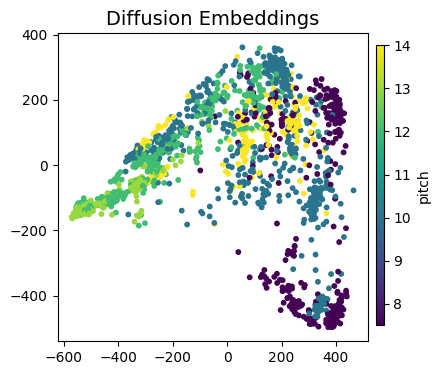

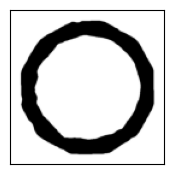

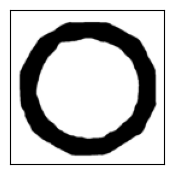

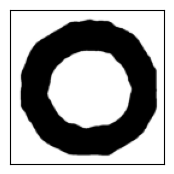

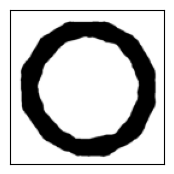

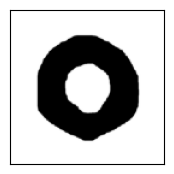

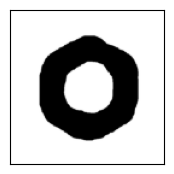

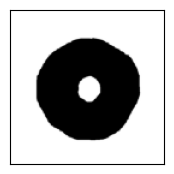

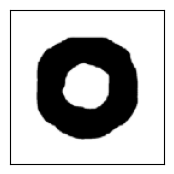

In [85]:
high_wl_rings = all_images[emb_pca[:,0]<-397]
low_wl_rings = all_images[emb_pca[:,0]>398]

for i in range(high_wl_rings.shape[0]):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax.imshow(high_wl_rings[i,:], cmap='Greys',)
    ax.set_yticks([])
    ax.set_xticks([])

for i in range(low_wl_rings.shape[0]):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2, 2))
    ax.imshow(low_wl_rings[i,:], cmap='Greys',)
    ax.set_yticks([])
    ax.set_xticks([])

Similarity Matrix:
a: ['1.021', '0.003', '0.003', '0.944']
b: ['0.003', '1.022', '1.013', '0.004']
c: ['0.003', '1.013', '1.022', '0.004']
d: ['0.944', '0.004', '0.004', '1.021']


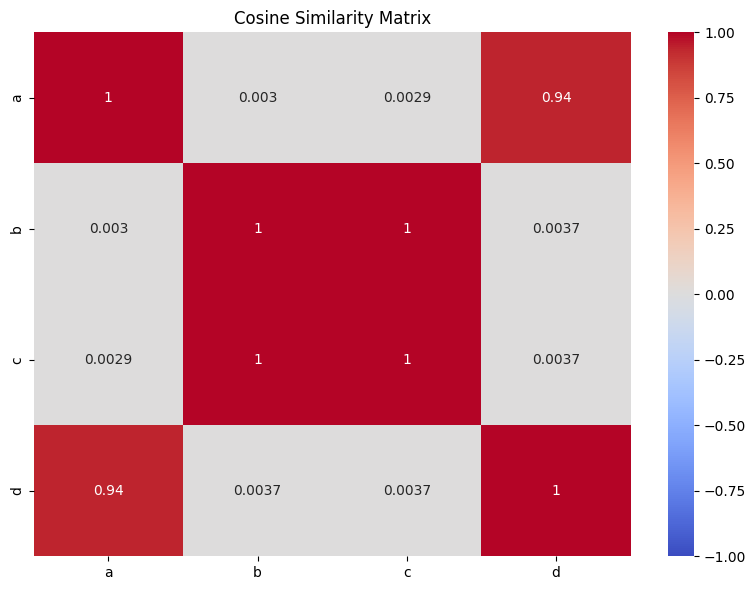

In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Create arrays
arrays = [
    all_embeddings[0].flatten(),      # a
    all_embeddings[1].flatten(),      # b  
    all_embeddings[2].flatten(),      # c
    all_embeddings[3].flatten()     # d
]

names = ['a', 'b', 'c', 'd']

# Create similarity matrix
similarity_matrix = cosine_similarity(arrays)

print("Similarity Matrix:")
for i, row in enumerate(similarity_matrix):
    print(f"{names[i]}: {[f'{x:.3f}' for x in row]}")

# Visualize the similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, 
            xticklabels=names, 
            yticklabels=names,
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1,
            center=0)
plt.title('Cosine Similarity Matrix')
plt.tight_layout()
plt.show()

In [15]:
images_true, params_true, props_true = [], [], []
for batch in data:    
    images, params, props = batch
    images_true.append(images.numpy())
    params_true.append(params.numpy())
    props_true.append(props.numpy())

images_true = np.concatenate(images_true, axis=0)
params_true = np.concatenate(params_true, axis=0)
props_true = np.concatenate(props_true, axis=0)

/home/users/kaiyuana001/.conda/envs/microring/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [19]:
images_gen = torch.load("results/images_raw_2025-09-16_12-05", map_location=torch.device('cpu'))
params_gen = np.loadtxt("results/params_2025-09-16_12-05.csv", delimiter=',')
params_gen = param_scaler.transform(params_gen)
params_gen = torch.tensor(params_gen, dtype=torch.float32)
props_gen = model(images_gen, params_gen).detach().numpy()
props_gen = prop_scaler.inverse_transform(props_gen)

df1 = pd.DataFrame(all_props, columns=['Threshold', 'Wavelength'])
df1['Batch'] = 'Training'

df2 = pd.DataFrame(props_gen, columns=['Threshold', 'Wavelength'])
df2['Batch'] = 'Generated (predicted)'

df = pd.concat([df1, df2])

In [31]:
prop_scaler.inverse_transform(np.array([[-2.0, 1.6]]))


array([[  41.69232513, 1168.18305747]])

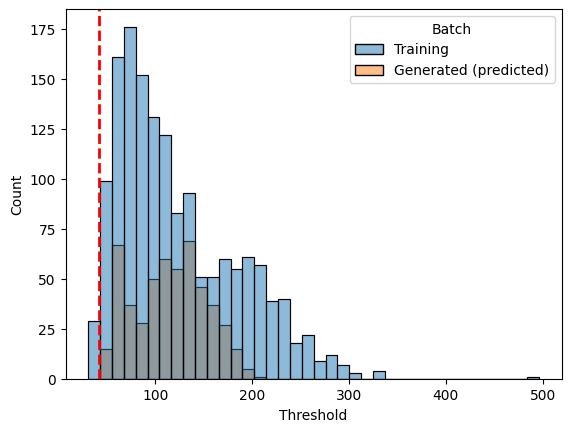

In [20]:
ax = sb.histplot(df, x='Threshold', hue='Batch')
ax.axvline(x=42, color='red', linestyle='--', linewidth=2)
#ax.set_title('CFG=7')

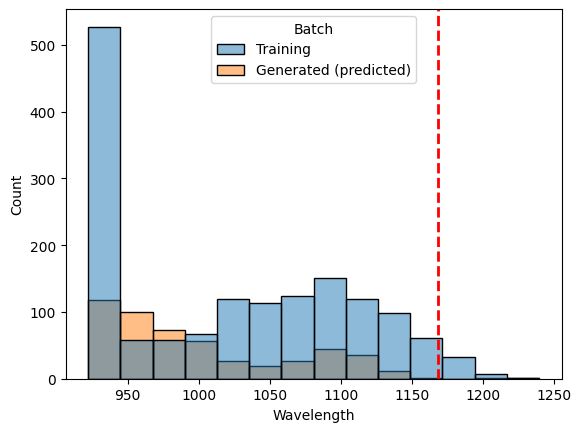

In [21]:
ax = sb.histplot(df, x='Wavelength', hue='Batch')
ax.axvline(x=1168, color='red', linestyle='--', linewidth=2)
#ax.set_title('CFG=1')

In [ ]:
# obj_predicted = model(images, params)
# obj_predicted = prop_scaler.inverse_transform(obj_predicted)